In [76]:
%matplotlib inline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn

import matplotlib.pyplot as plt
from sklearn import preprocessing, linear_model
from tools import gen_linear, display_graph,display_tab, plot_data, gen_arti, plot_frontiere

In [121]:
dataA_train = pd.read_csv('data/classificationA.train', sep='\t', header=None)
dataB_train = pd.read_csv('data/classificationB.train', sep='\t', header=None)
dataC_train = pd.read_csv('data/classificationC.train', sep='\t', header=None)

dataA_test = pd.read_csv('data/classificationA.test', sep='\t', header=None)
dataB_test = pd.read_csv('data/classificationB.test', sep='\t', header=None)
dataC_test = pd.read_csv('data/classificationC.test', sep='\t', header=None)

In [124]:
XA_train, yA_train = dataA_train.values[:,0:2], dataA_train.values[:,2]
XB_train, yB_train = dataB_train.values[:,0:2], dataB_train.values[:,2]
XC_train, yC_train = dataC_train.values[:,0:2], dataC_train.values[:,2]

XA_test, yA_test = dataA_test.values[:,0:2], dataA_test.values[:,2]
XB_test, yB_test = dataB_test.values[:,0:2], dataB_test.values[:,2]
XC_test, yC_test = dataC_test.values[:,0:2], dataC_test.values[:,2]
                                                                   

Text(0.5, 1.0, 'Test C')

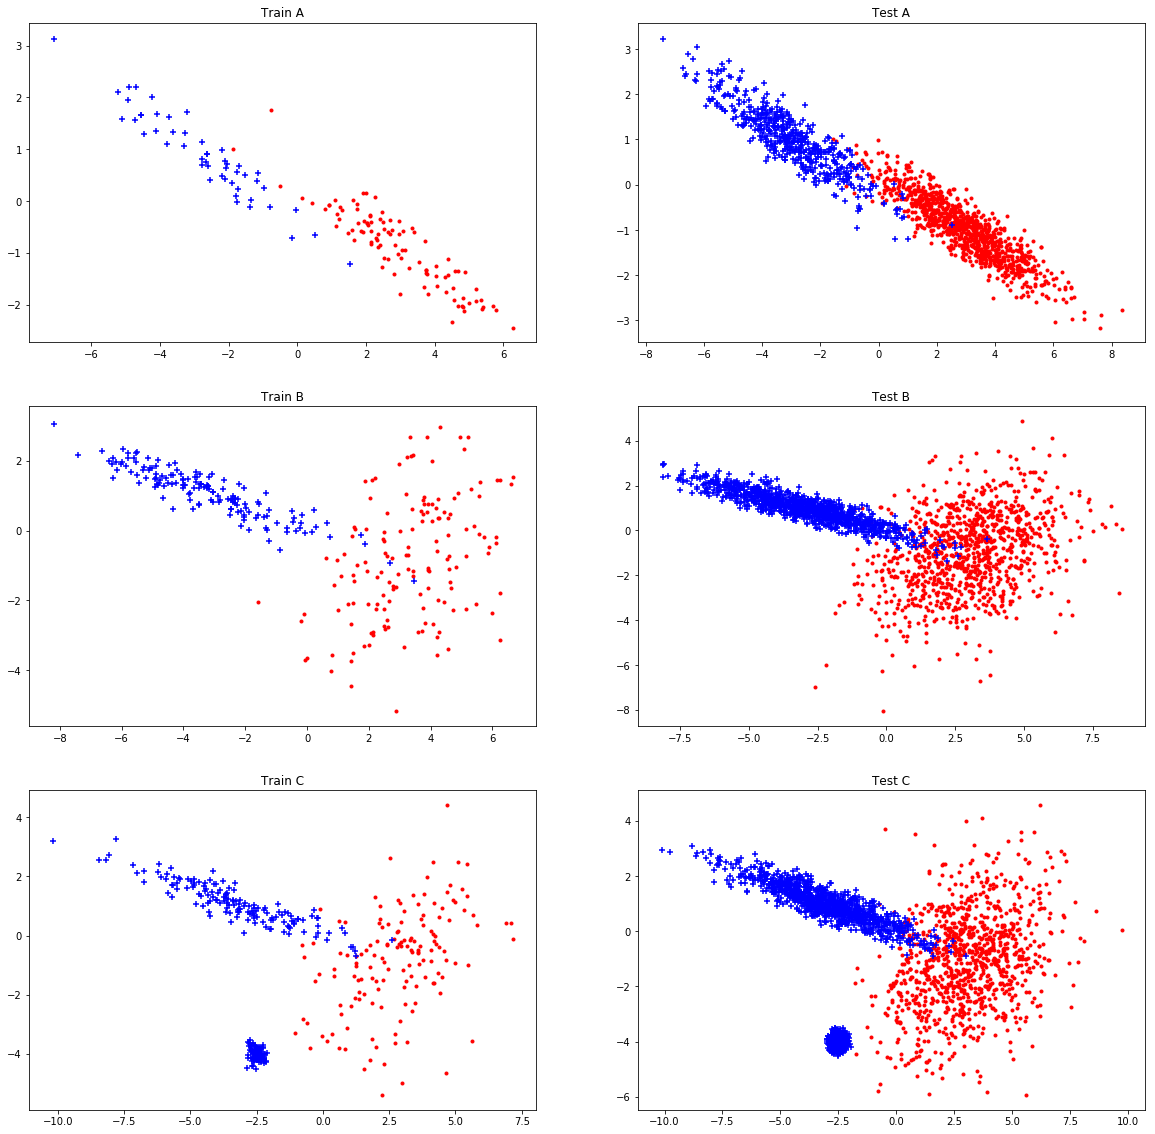

In [141]:
### Donnees artificielles, essais sur la variance des gaussiennes
plt.figure(figsize=(20,20))

plt.subplot(3,2,1)
plot_data(XA_train,yA_train)
plt.title('Train A')

plt.subplot(3,2,2)
plot_data(XA_test,yA_test)
plt.title('Test A')

plt.subplot(3,2,3)
plot_data(XB_train,yB_train)
plt.title('Train B')

plt.subplot(3,2,4)
plot_data(XB_test,yB_test)
plt.title('Test B')

plt.subplot(3,2,5)
plot_data(XC_train,yC_train)
plt.title('Train C')

plt.subplot(3,2,6)
plot_data(XC_test,yC_test)
plt.title('Test C')

In [163]:
class Model():
    def misclassification_error(self,X,y):
        y_pred = self.predict(X)
        return np.sum(y_pred!=y)/y.shape[0]
    
    def plot_data_frontiere(self,X,y,c=0.01,step=500):
        plt.figure(figsize=(10,10))
        self.fit(X,y)
        plot_data(X,y)
        plot_frontiere(X,lda.predict, alpha_c=0.1,step=200)
        plt.title(self.model_name)
        

# Generative Model(LDA)

In [171]:
class LDA(Model):
    model_name = 'LDA'
    def fit(self,X,y):
        n = y.shape[0]
        Ny = np.sum(y==0)
        
        pi = Ny/n
        
        mu0 = np.sum(X[y==0],axis=0)/(Ny)
        mu1 = np.sum(X[y==1],axis=0)/(n-Ny)
        
        sigma = ((X[y==0]-mu0).T.dot((X[y==0]-mu0))+(X[y==1]-mu1).T.dot((X[y==1]-mu1)))/n
        
        self.mu0 = mu0
        self.mu1 = mu1
        self.sigma = sigma
        self.pi = pi
        self.sigma_inv = np.linalg.inv(self.sigma)
        
    def predict_proba(self,X):
        
        if X.ndim != 1:
            p0 = self.pi*np.exp(np.apply_along_axis(lambda x:(x-self.mu0).dot(self.sigma_inv).dot((x-self.mu0).T), arr=X, axis=1))
            p1 = (1-self.pi)*np.exp(np.apply_along_axis(lambda x:(x-self.mu1).dot(self.sigma_inv).dot((x-self.mu1).T), arr=X, axis=1))
            p0 = p0/(p0+p1)
        else:
            p0 = self.pi*np.exp(X-self.mu0).dot(self.sigma_inv).dot((X-self.mu0).T)
            p1 = (1-self.pi)*np.exp(X-self.mu1).dot(self.sigma_inv).dot((X-self.mu1).T)
            p0 = p0/(p0+p1)
        
        return p0

    def predict(self,X):
        return self.predict_proba(X)>0.5


In [172]:
lda = LDA()

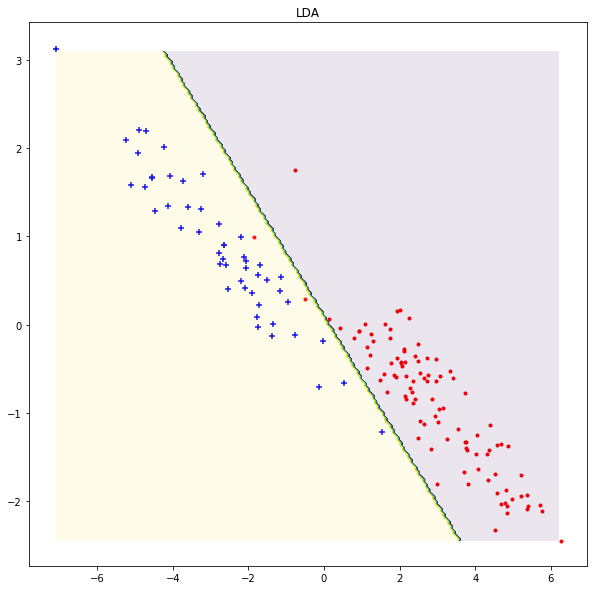

In [173]:
lda.plot_data_frontiere(XA_train, yA_train)

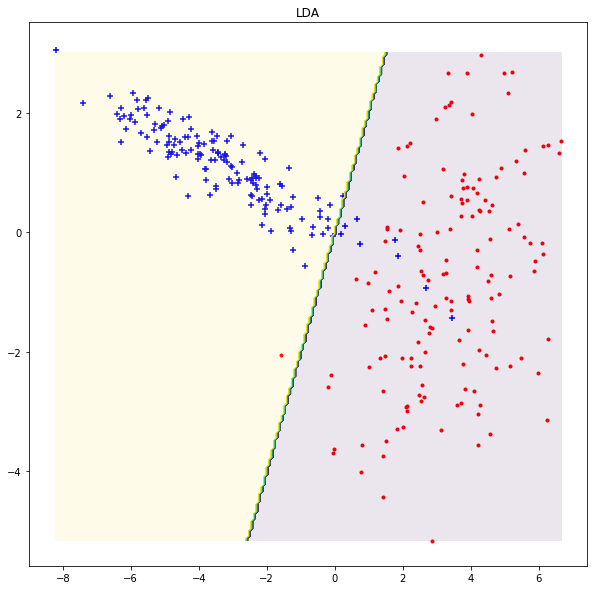

In [174]:
lda.plot_data_frontiere(XB_train, yB_train)

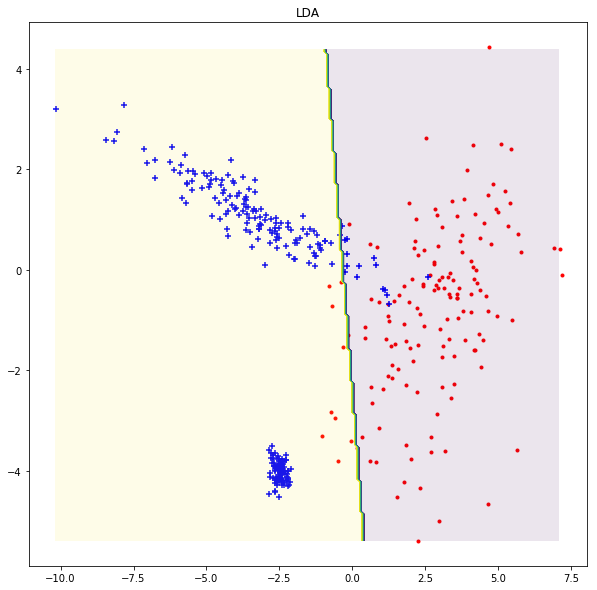

In [175]:
lda.plot_data_frontiere(XC_train, yC_train)

In [182]:
lda.fit(XA_train, yA_train)
misclass_Atrain = lda.misclassification_error(XA_train, yA_train)
misclass_Atest = lda.misclassification_error(XA_test, yA_test)

lda.fit(XB_train, yB_train)
misclass_Btrain = lda.misclassification_error(XB_train, yB_train)
misclass_Btest = lda.misclassification_error(XB_test, yB_test)

lda.fit(XC_train, yC_train)
misclass_Ctrain = lda.misclassification_error(XC_train, yC_train)
misclass_Ctest = lda.misclassification_error(XC_test, yC_test)

In [189]:
print(misclass_Atrain, misclass_Atest)
print(misclass_Btrain, misclass_Btest)
print(misclass_Ctrain, misclass_Ctest)

0.013333333333333334 0.024666666666666667
0.03 0.0415
0.06 0.043666666666666666


# Linear Regression

In [195]:
class LinearRegression(Model):
    model_name = 'Linear Regression'
    def fit(self,X,Y):
        offset = np.ones(X.shape[0])
        offset=offset.reshape(-1,1)
        X=np.hstack((offset,X))
        w =  np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y) 
        self.w = w 
        return w

    def predict_proba(self,X, w=None):
        if w is None:
            w = self.w
        #we add a colon of ones for the offset
        offset = np.ones(X.shape[0])
        offset=offset.reshape(-1,1)
        X=np.hstack((offset,X))
        #We check the matrix dimensions to be compatible
        assert(X.shape[-1]==w.shape[0])

        return X.dot(w)

    def predict(self,X, w=None):
        if w is None:
            w = self.w
        return self.predict_proba(X,w)>0.5


In [196]:
lin = LinearRegression()

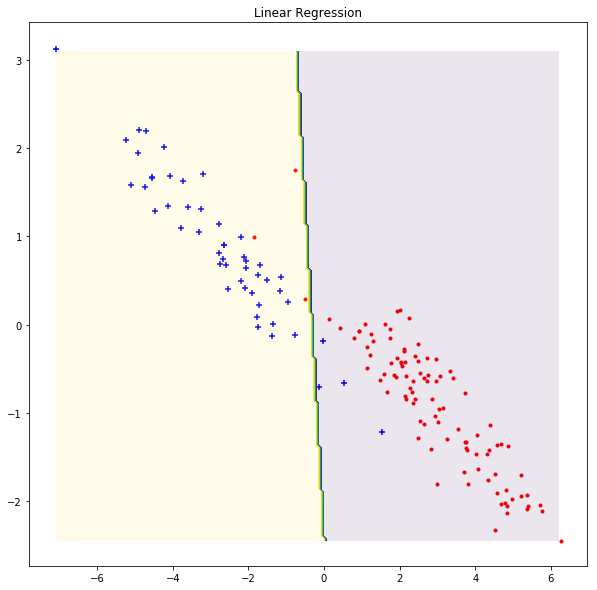

In [197]:
lin.plot_data_frontiere(XA_train, yA_train)

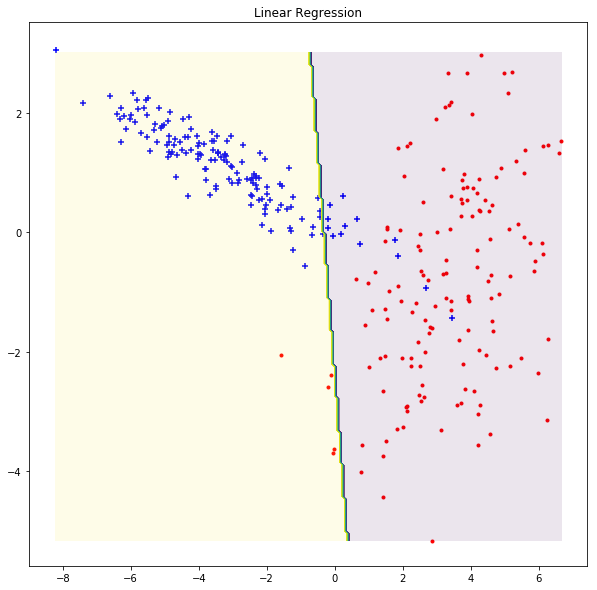

In [198]:
lin.plot_data_frontiere(XB_train, yB_train)

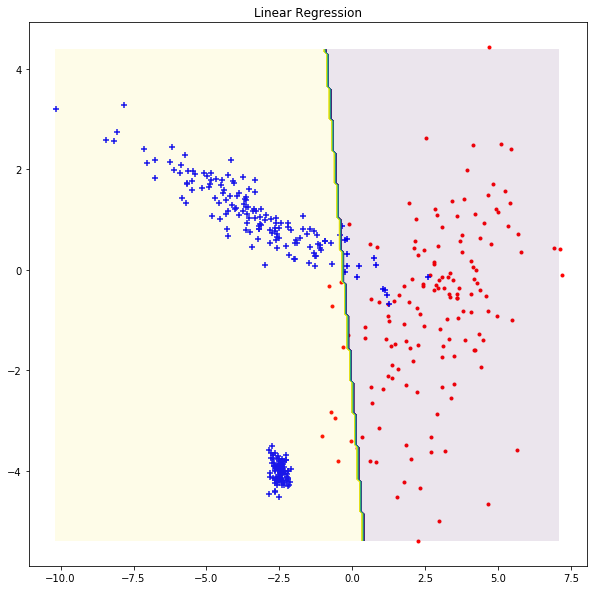

In [202]:
lin.plot_data_frontiere(XC_train, yC_train)

In [200]:
lin.fit(XA_train, yA_train)
misclass_Atrain = lda.misclassification_error(XA_train, yA_train)
misclass_Atest = lda.misclassification_error(XA_test, yA_test)

lin.fit(XB_train, yB_train)
misclass_Btrain = lda.misclassification_error(XB_train, yB_train)
misclass_Btest = lda.misclassification_error(XB_test, yB_test)

lin.fit(XC_train, yC_train)
misclass_Ctrain = lda.misclassification_error(XC_train, yC_train)
misclass_Ctest = lda.misclassification_error(XC_test, yC_test)

In [201]:
print(misclass_Atrain, misclass_Atest)
print(misclass_Btrain, misclass_Btest)
print(misclass_Ctrain, misclass_Ctest)

0.04666666666666667 0.023333333333333334
0.06 0.068
0.06 0.043666666666666666
